
import sys
print("Python version:", sys.version)#!conda install -y cudatoolkit
#!pip install bitsandbytes
!pip install transformers==4.33.2
!pip install datasets
!pip install evaluate
!pip install peft
!pip install accelerate -U
!pip install transformers[torch]
!pip install -r requirements.txt

In [2]:
%pip install -q -U torch==2.0.1 bitsandbytes==0.40.2
%pip install -q -U transformers==4.31.0 peft==0.4.0 accelerate==0.21.0
%pip install -q -U datasets py7zr einops tensorboardX
!pip install evaluate
# Add installed cuda runtime to path for bitsandbytes
import os
import nvidia

cuda_install_dir = '/'.join(nvidia.__file__.split('/')[:-1]) + '/cuda_runtime/lib/'
os.environ['LD_LIBRARY_PATH'] =  cuda_install_dir


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip ins

In [2]:
!pip install wandb
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'text_classifier.ipynb'
import wandb
wandb.login()



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: brc4cb (christ_research). Use `wandb login --relogin` to force relogin


True

In [3]:
from collections import defaultdict
import copy
import json
import os
import sys
#sys.path.append("/home/sagemaker-user/bitsandbytes")
#os.environ['LD_LIBRARY_PATH'] = '/opt/conda/lib/'
from os.path import exists, join, isdir
from dataclasses import dataclass, field
import sys
from typing import Optional, Dict, Sequence
import numpy as np
from tqdm import tqdm
import logging
#import bitsandbytes as bnb
import pandas as pd

import torch
torch.cuda.init()
print(torch.cuda.is_available())
import os
#os.environ['TRANSFORMERS_CACHE'] = '/project/SDS/research/christ_research/Llama 2/llama2-7b/cache'
import transformers
from torch.nn.utils.rnn import pad_sequence
import argparse
# from transformers import (
#     AutoTokenizer,
#     AutoModelForCausalLM,
#     set_seed,
#     Seq2SeqTrainer,
# #    BitsAndBytesConfig,
#     LlamaTokenizer

# )
from datasets import load_dataset, Dataset
import evaluate

# from peft import (
#     prepare_model_for_kbit_training,
#     LoraConfig,
#     get_peft_model,
#     PeftModel,
#     TaskType
# )
#from peft.tuners.lora import LoraLayer
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
#from dotenv import load_dotenv
import os
os.environ["WANDB_PROJECT"]="text_classifiers"
torch.backends.cuda.matmul.allow_tf32 = True

# Load the environmental variables from the .env file
#load_dotenv()

#token = os.getenv('text_classifier_token')

#from huggingface_hub import login
#login(token = token)

from datasets import load_dataset, DatasetDict

True


In [4]:
import random

In [5]:
df = pd.read_csv('data/appropriateness.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/appropriateness.csv')
df

,label,text
0,1,Question: LeBron James has 30000 points. He ha...
1,1,Question: A class has 120 students. 40 of them...
2,1,Question: Naruto has 5000 ryo. He spends 1000 ...
3,1,Question: Hello Kitty has 12 pencils. She boug...
4,1,Question: Wonder Woman's lasso of truth can ho...
...,...,...
2655,0,Question: 3 unicorns ate 12 apples. 2 unicorns...
2656,0,"Question: If 1000 V-Bucks cost $10, how many V..."
2657,0,Question: A field hockey game has 11 players p...
2658,0,Question: 100 turtles are at the pond. 10 turt...


In [6]:
neg_weight = df['label'].mean()
pos_weight = 1 - neg_weight

In [27]:
neg_weight

0.8007518796992481

In [28]:
pos_weight

0.1992481203007519

In [8]:
df = pd.read_csv('data/appropriateness.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2.drop('Unnamed: 0', axis =1)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/appropriateness_balanced.csv')
df2

,label,text
0,0,Question: 15000 strawberries are in 500 basket...
1,1,Question: The Wombats and the Kangaroos are tw...
2,0,Question: Steph Curry has 100 3-point shots. H...
3,1,Question: LeBron James is the all-time leading...
4,0,Question: A cheerleading squad of 100 girls is...
...,...,...
1835,1,Question: Patrick Mahomes has 151 touchdowns. ...
1836,1,Question: Spiderman has 1000 web-shooters. He ...
1837,1,Question: A 24-hour bakery bakes 120 loaves of...
1838,1,Question: Hello Kitty has 35 pencils. She boug...


In [7]:
# Load the dataset
#dataset = load_dataset('csv', data_files="data/appropriateness_balanced.csv")
dataset = load_dataset('csv', data_files="data/appropriateness.csv")
#dataset= load_dataset('csv', data_files="data/appropriateness_test.csv")

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
train_test_valid_dataset['valid'][2]

{'Unnamed: 0': 2564,
 'label': 0,
 'text': 'Question: The Red Ranger, Yellow Ranger, and Blue Ranger are each 6 feet tall. The Pink Ranger and Green Ranger are 1 inch taller than the other Rangers. How tall are all the Power Rangers put together?\nAnswer: 32'}

In [9]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer = AutoTokenizer.from_pretrained("roberta-base")
#tokenizer = AutoTokenizer.from_pretrained("albert-large-v2")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2128 [00:00<?, ? examples/s]

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

In [10]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")
balanced_accuracy = evaluate.load('hyperml/balanced_accuracy')
roc_auc_score= evaluate.load('roc_auc')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')

import numpy as np
import torch.nn.functional as F
def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy")
    balanced_accuracy = evaluate.load('hyperml/balanced_accuracy')
    roc_auc_score= evaluate.load('roc_auc')
    f1 = evaluate.load('f1')
    precision = evaluate.load('precision')
    recall = evaluate.load('recall')
    predictions, labels = eval_pred
    
    predicted_labels = np.argmax(predictions, axis=1)
    # Convert NumPy array to PyTorch tensor
    predictions_tensor = torch.from_numpy(predictions)
    
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(predictions_tensor, dim=1)
    
    # Convert probabilities back to NumPy array
    probabilities_np = probabilities.numpy()
    
    accuracy = accuracy.compute(predictions=predicted_labels, references=labels)
    balanced_accuracy = balanced_accuracy.compute(predictions=predicted_labels, references=labels)
    roc_auc = roc_auc_score.compute(references = labels, prediction_scores = probabilities_np[:, 1])
    f1 = f1.compute(predictions=predicted_labels, references=labels)
    precision = precision.compute(predictions=predicted_labels, references=labels)
    recall = recall.compute(predictions=predicted_labels, references=labels)
    return {'accuracy':  accuracy, 'balanced_accuracy' : balanced_accuracy, 'f1':f1, 'auc': roc_auc, 'precision': precision, 'recall': recall}

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "NOT APPROPRIATE", 1: "APPROPRIATE"}
label2id = {"NOT APPROPRIATE": 0, "APPROPRIATE": 1}

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# model = AutoModelForSequenceClassification.from_pretrained(
#     "roberta-base", num_labels=2, id2label=id2label, label2id=label2id
# )
# for param in model.parameters():
#     param.requires_grad = False
    
# for param in model.classifier.parameters():
#     param.requires_grad = True
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
#NEWLY ADDED
# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model)

# peft_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.1,
# )      

# model = get_peft_model(model, peft_config)

#END NEWLY ADDED
# training_args = TrainingArguments(
#     output_dir="text_classifier_llama",
#     learning_rate=2e-5,
#     per_device_train_batch_size=1,
#   # auto_find_batch_size = True,
#     num_train_epochs=8,
#     weight_decay=0.01,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True, 
#     bf16=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch.nn.functional as F
from torch import nn
class_weights = torch.tensor([neg_weight, pos_weight], device = model.device)

class BertTrainer(Trainer):
    def __init__(self, penalty_factor=2.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.penalty_factor = penalty_factor

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # Assuming labels are passed in the inputs
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)

        # Assuming binary classification, so consider only the positive class (index 1)
        positive_class_probabilities = probabilities[:, 1]

        # Custom loss calculation
        loss = F.binary_cross_entropy(positive_class_probabilities, labels.float())

        # Penalize false positives more heavily based on the defined penalty factor
        false_positive_mask = (positive_class_probabilities > 0.5) & (labels == 0)
        loss += torch.sum(false_positive_mask.float()) * self.penalty_factor

        if return_outputs:
            return loss, outputs
        return loss

class WeightedBertTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(torch.float32)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # Assuming labels are passed in the inputs
        outputs = model(**inputs)
        logits = outputs.logits
        
        # # Convert logits and labels to Float
        #logits = logits.to(torch.float32)
        # labels = labels.to(torch.float32)
        # labels = labels.to(device)
        
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)

        # Assuming binary classification, so consider only the positive class (index 1)
        positive_class_probabilities = probabilities[:, 1]
        # Use weighted binary cross-entropy loss
        if self.class_weights is not None:
            # Ensure class_weights tensor matches the size of the labels tensor
            loss_fct = nn.CrossEntropyLoss(weight = self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            
        else:
            # If class weights are not provided, use regular binary cross-entropy loss
            loss = F.binary_cross_entropy(positive_class_probabilities, labels.float())
                
        if return_outputs:
            return loss, outputs
        return loss
from transformers.optimization import Adafactor, AdafactorSchedule

optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None, weight_decay = .984687)
lr_scheduler = AdafactorSchedule(optimizer)

In [16]:
class_weights

tensor([0.8008, 0.1992], device='cuda:0', dtype=torch.float64)

In [31]:
    
training_args = TrainingArguments(
    output_dir="appropriateness_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=.9,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to = 'wandb', 
    run_name = 'distilbert_appropriateness',
    logging_strategy = 'epoch',
    logging_steps = 1)

trainer = WeightedBertTrainer(class_weights = class_weights,
     model=model,
     args=training_args,
     train_dataset=tokenized_train_test_valid_dataset["train"],
     eval_dataset=tokenized_train_test_valid_dataset["valid"],
     tokenizer=tokenizer,
     data_collator=data_collator,
     compute_metrics=compute_metrics,
     #optimizers=(optimizer, lr_scheduler)
 )
# trainer = BertTrainer(penalty_factor=4,
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_test_valid_dataset["train"],
#     eval_dataset=tokenized_train_test_valid_dataset["valid"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
#     #optimizers=(optimizer, lr_scheduler)
# )
#trainer.train(resume_from_checkpoint=True)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Auc,Precision,Recall
1,0.628600,0.658083,{'accuracy': 0.7556390977443609},{'balanced_accuracy': 0.5950762599469496},{'f1': 0.8491879350348027},{'roc_auc': 0.6483753315649867},{'precision': 0.820627802690583},{'recall': 0.8798076923076923}
2,0.583700,0.688604,{'accuracy': 0.6466165413533834},{'balanced_accuracy': 0.6061836870026525},{'f1': 0.7499999999999999},{'roc_auc': 0.6506962864721485},{'precision': 0.8392857142857143},{'recall': 0.6778846153846154}
3,0.479100,0.763402,{'accuracy': 0.6954887218045113},{'balanced_accuracy': 0.5876989389920424},{'f1': 0.8},{'roc_auc': 0.6277354111405835},{'precision': 0.8223350253807107},{'recall': 0.7788461538461539}
4,0.382700,1.210985,{'accuracy': 0.7631578947368421},{'balanced_accuracy': 0.6371850132625995},{'f1': 0.8503562945368172},{'roc_auc': 0.6305537135278514},{'precision': 0.8403755868544601},{'recall': 0.8605769230769231}
5,0.312400,1.114098,{'accuracy': 0.7518796992481203},{'balanced_accuracy': 0.5988892572944298},{'f1': 0.8457943925233644},{'roc_auc': 0.6398375331564986},{'precision': 0.8227272727272728},{'recall': 0.8701923076923077}
6,0.257300,1.393819,{'accuracy': 0.7631578947368421},{'balanced_accuracy': 0.5874502652519894},{'f1': 0.8558352402745996},{'roc_auc': 0.6319628647214853},{'precision': 0.8165938864628821},{'recall': 0.8990384615384616}
7,0.226200,1.435472,{'accuracy': 0.7631578947368421},{'balanced_accuracy': 0.6123176392572944},{'f1': 0.8531468531468531},{'roc_auc': 0.6627984084880636},{'precision': 0.8280542986425339},{'recall': 0.8798076923076923}
8,0.193300,1.476415,{'accuracy': 0.7894736842105263},{'balanced_accuracy': 0.616710875331565},{'f1': 0.8727272727272727},{'roc_auc': 0.6607675729442971},{'precision': 0.8275862068965517},{'recall': 0.9230769230769231}


TrainOutput(global_step=1064, training_loss=0.3829072794519869, metrics={'train_runtime': 201.1497, 'train_samples_per_second': 84.633, 'train_steps_per_second': 5.29, 'total_flos': 338222385618432.0, 'train_loss': 0.3829072794519869, 'epoch': 8.0})

In [24]:
#Clear cache when needed
import gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 0.6454976797103882,
 'eval_accuracy': {'accuracy': 0.7781954887218046},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.6270572745227123},
 'eval_f1': {'f1': 0.8643678160919541},
 'eval_auc': {'roc_auc': 0.6591742687858554},
 'eval_precision': {'precision': 0.8623853211009175},
 'eval_recall': {'recall': 0.8663594470046083},
 'eval_runtime': 1.6268,
 'eval_samples_per_second': 163.509,
 'eval_steps_per_second': 10.45,
 'epoch': 8.0}

## Evaluate model on questions from Llama, Llema, Mammoth and Mathwell

In [33]:
df= pd.read_csv('data/llama_appropriateness.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/llama_appropriateness.csv')

df= pd.read_csv('data/llema_appropriateness.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/llema_appropriateness.csv')

df= pd.read_csv('data/mammoth_appropriateness.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/mammoth_appropriateness.csv')

df= pd.read_csv('data/mathwell_appropriateness.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/mathwell_appropriateness.csv')

df= pd.read_csv('data/llama_solvability.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/llama_solvability.csv')

df= pd.read_csv('data/llema_solvability.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/llema_solvability.csv')

df= pd.read_csv('data/mammoth_solvability.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/mammoth_solvability.csv')

df= pd.read_csv('data/mathwell_solvability.csv')
df = df.dropna()
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/mathwell_solvability.csv')

In [34]:
llama = load_dataset('csv', data_files="data/llama_appropriateness.csv")
tokenized_llama = llama.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_llama['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

{'eval_loss': 0.6905992031097412,
 'eval_accuracy': {'accuracy': 0.7981220657276995},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.539378612716763},
 'eval_f1': {'f1': 0.8847184986595175},
 'eval_auc': {'roc_auc': 0.5638728323699422},
 'eval_precision': {'precision': 0.825},
 'eval_recall': {'recall': 0.953757225433526},
 'eval_runtime': 1.4999,
 'eval_samples_per_second': 142.012,
 'eval_steps_per_second': 9.334,
 'epoch': 8.0}

In [35]:
llema = load_dataset('csv', data_files="data/llema_appropriateness.csv")
tokenized_llema = llema.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_llema['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

{'eval_loss': 0.7522148489952087,
 'eval_accuracy': {'accuracy': 0.45161290322580644},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.4842436974789916},
 'eval_f1': {'f1': 0.575},
 'eval_auc': {'roc_auc': 0.4477415966386555},
 'eval_precision': {'precision': 0.4423076923076923},
 'eval_recall': {'recall': 0.8214285714285714},
 'eval_runtime': 1.246,
 'eval_samples_per_second': 99.516,
 'eval_steps_per_second': 6.42,
 'epoch': 8.0}

In [36]:
mammoth = load_dataset('csv', data_files="data/mammoth_appropriateness.csv")
tokenized_mammoth = mammoth.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_mammoth['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

{'eval_loss': 0.7383445501327515,
 'eval_accuracy': {'accuracy': 0.6651376146788991},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.5077608508192009},
 'eval_f1': {'f1': 0.7943661971830986},
 'eval_auc': {'roc_auc': 0.5313787486825716},
 'eval_precision': {'precision': 0.6778846153846154},
 'eval_recall': {'recall': 0.9591836734693877},
 'eval_runtime': 1.4669,
 'eval_samples_per_second': 148.612,
 'eval_steps_per_second': 9.544,
 'epoch': 8.0}

In [37]:
mathwell = load_dataset('csv', data_files="data/mathwell_appropriateness.csv")
tokenized_mathwell = mathwell.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_mathwell['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

{'eval_loss': 0.6277484893798828,
 'eval_accuracy': {'accuracy': 0.852017937219731},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.6124338624338624},
 'eval_f1': {'f1': 0.9168765743073048},
 'eval_auc': {'roc_auc': 0.674225245653817},
 'eval_precision': {'precision': 0.9054726368159204},
 'eval_recall': {'recall': 0.9285714285714286},
 'eval_runtime': 1.57,
 'eval_samples_per_second': 142.041,
 'eval_steps_per_second': 8.917,
 'epoch': 8.0}

In [18]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[ 0.01265527,  0.26840028],
       [ 0.01784369,  0.2681898 ],
       [ 0.01990037,  0.2682471 ],
       [ 0.07549401, -0.01162307],
       [ 0.02191722,  0.27593637],
       [ 0.01073697,  0.2662236 ],
       [ 0.01795776,  0.26869363],
       [ 0.01942494,  0.27136   ],
       [ 0.01953371,  0.26950413],
       [ 0.01973491,  0.2726375 ],
       [ 0.01492538,  0.26843745],
       [ 0.03497325,  0.26706448],
       [ 0.02576424,  0.27442026],
       [ 0.02102856,  0.27209538],
       [ 0.02315938,  0.27173033],
       [ 0.02622212,  0.27267003],
       [ 0.02574735,  0.27397898],
       [ 0.02661827,  0.26189482],
       [ 0.02601069,  0.27296177],
       [ 0.01875574,  0.26940358],
       [ 0.02159994,  0.2710167 ],
       [ 0.02863638,  0.2728095 ],
       [ 0.01718465,  0.26865175],
       [ 0.02243502,  0.2735988 ],
       [ 0.01923499,  0.27042824],
       [ 0.01306316,  0.26654005],
       [ 0.03322511,  0.26591364],
       [ 0.02015051,  0.26

In [21]:
import torch
import torch.nn.functional as F
def compute_fp_tp(predictions):
    fp = 0
    tn = 0
    tp = 0
    fn = 0
    y_scores = predictions[0]
    y_scores = torch.tensor(y_scores)
    y_scores = F.softmax(y_scores, dim=1).numpy()
    y_scores= np.argmax(y_scores, axis=1)
    y_true = predictions[1]
    for i in range(0, len(y_scores)):
        if y_scores[i] == 1 and y_true[i] == 0:
            fp+=1
        if y_scores[i] == 0 and y_true[i] == 0:
            tn+=1
        if y_scores[i] == 1 and y_true[i] == 1:
            tp+=1
        if y_scores[i] == 0 and y_true[i] == 1:
            fn+=1
    tpr = (tp)/(tp+fn)
    fpr = (fp)/(fp+tn)
    return (fpr, tpr)
compute_fp_tp(predictions)
#want fpr (false positive rate) to be small and tpr (true positive rate) to be big)
#originally fpr was at .649

(0.5280898876404494, 0.7989690721649485)

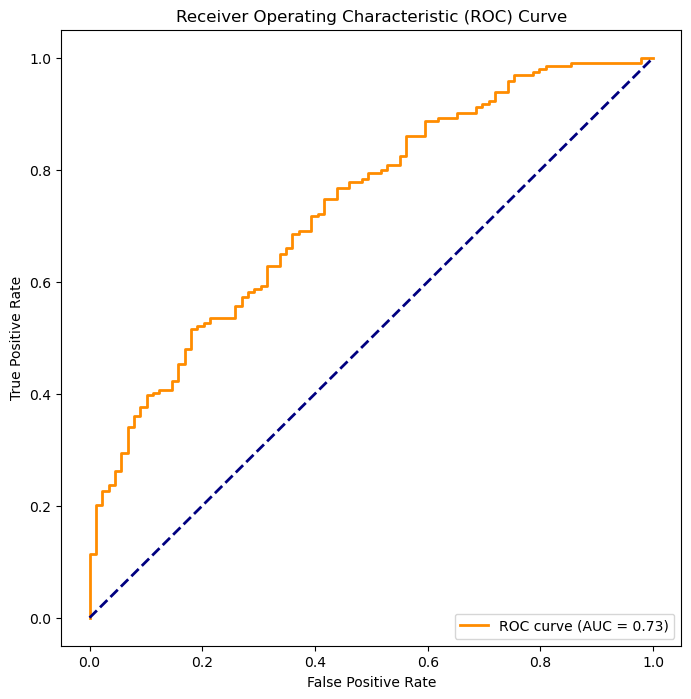

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Solvability Classifier

In [38]:
df = pd.read_csv('data/solvability.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
neg_weight = df['label'].mean()
pos_weight = 1 - neg_weight
df.to_csv('data/solvability.csv')
df

,label,text
0,1,LeBron James has 30000 points. He has 1000 mor...
1,1,A class has 120 students. 40 of them are in th...
2,0,A 3-pound cake of butter is 90% fat. 3.5 ounce...
3,0,A train is 1500 feet long. 200 of its cars are...
4,1,Naruto has 5000 ryo. He spends 1000 ryo on a n...
...,...,...
3228,1,A field hockey game has 11 players per team. T...
3229,1,100 turtles are at the pond. 10 turtles are ea...
3230,0,Barbie has 1200 Instagram followers. 200 more ...
3231,1,1234567890 is a 10-digit number. \nHow many 3-...


In [124]:
df = pd.read_csv('data/solvability.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/solvability_balanced.csv')
df2

,Unnamed: 0,label,text
0,2190,0,Question: Captain America has 120 throwing sta...
1,17,1,"Question: Harry, Ron, and Hermione are in the ..."
2,694,1,"Question: Captain Marvel, a.k.a. Carol Danvers..."
3,1758,0,"Question: Steph Curry, the 2-time MVP, has 100..."
4,2533,1,"Question: In a bakery, the baker bakes 200 bun..."
...,...,...,...
771,2442,1,Question: The 10-member cheerleading squad is ...
772,393,0,Question: 1000 players are in a Fortnite match...
773,2272,1,"Question: In the first Harry Potter book, ther..."
774,1029,1,"Question: The 4 Ninja Turtles, Leonardo, Donat..."


In [39]:
# Load the dataset
#dataset = load_dataset('csv', data_files="data/solvability_balanced.csv")
dataset = load_dataset('csv', data_files="data/solvability.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [40]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2586 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

In [41]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")
balanced_accuracy = evaluate.load('hyperml/balanced_accuracy')
roc_auc_score= evaluate.load('roc_auc')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')

import numpy as np
import torch.nn.functional as F
def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy")
    balanced_accuracy = evaluate.load('hyperml/balanced_accuracy')
    roc_auc_score= evaluate.load('roc_auc')
    f1 = evaluate.load('f1')
    precision = evaluate.load('precision')
    recall = evaluate.load('recall')
    predictions, labels = eval_pred
    
    predicted_labels = np.argmax(predictions, axis=1)
    # Convert NumPy array to PyTorch tensor
    predictions_tensor = torch.from_numpy(predictions)
    
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(predictions_tensor, dim=1)
    
    # Convert probabilities back to NumPy array
    probabilities_np = probabilities.numpy()
    
    accuracy = accuracy.compute(predictions=predicted_labels, references=labels)
    balanced_accuracy = balanced_accuracy.compute(predictions=predicted_labels, references=labels)
    roc_auc = roc_auc_score.compute(references = labels, prediction_scores = probabilities_np[:, 1])
    f1 = f1.compute(predictions=predicted_labels, references=labels)
    precision = precision.compute(predictions=predicted_labels, references=labels)
    recall = recall.compute(predictions=predicted_labels, references=labels)
    return {'accuracy':  accuracy, 'balanced_accuracy' : balanced_accuracy, 'f1':f1, 'auc': roc_auc, 'precision': precision, 'recall': recall}

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
#Training
id2label = {0: "NOT SOLVABLE", 1: "SOLVABLE"}
label2id = {"NOT SOLVABLE": 0, "SOLVABLE": 1}

In [42]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
class_weights = torch.tensor([neg_weight, pos_weight], device = model.device)
training_args = TrainingArguments(
    output_dir="solvability_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=.9,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to = 'wandb', 
    run_name = 'distilbert_solvability',
    logging_strategy = 'epoch',
    logging_steps = 1)

trainer = WeightedBertTrainer(class_weights = class_weights,
     model=model,
     args=training_args,
     train_dataset=tokenized_train_test_valid_dataset["train"],
     eval_dataset=tokenized_train_test_valid_dataset["valid"],
     tokenizer=tokenizer,
     data_collator=data_collator,
     compute_metrics=compute_metrics,
     #optimizers=(optimizer, lr_scheduler)
 )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Auc,Precision,Recall
1,0.697100,0.671891,{'accuracy': 0.7623456790123457},{'balanced_accuracy': 0.5243065693430657},{'f1': 0.8607594936708861},{'roc_auc': 0.5813138686131387},{'precision': 0.8530465949820788},{'recall': 0.8686131386861314}
2,0.615500,0.701394,{'accuracy': 0.7376543209876543},{'balanced_accuracy': 0.5832846715328467},{'f1': 0.8387096774193548},{'roc_auc': 0.6057664233576643},{'precision': 0.8735177865612648},{'recall': 0.8065693430656934}
3,0.453600,0.882307,{'accuracy': 0.7129629629629629},{'balanced_accuracy': 0.5768613138686132},{'f1': 0.8201160541586073},{'roc_auc': 0.6318978102189782},{'precision': 0.8724279835390947},{'recall': 0.7737226277372263}
4,0.364200,1.053735,{'accuracy': 0.8024691358024691},{'balanced_accuracy': 0.6052554744525548},{'f1': 0.8840579710144928},{'roc_auc': 0.6324817518248176},{'precision': 0.8776978417266187},{'recall': 0.8905109489051095}
5,0.262200,1.100422,{'accuracy': 0.7716049382716049},{'balanced_accuracy': 0.587007299270073},{'f1': 0.8634686346863468},{'roc_auc': 0.6486861313868613},{'precision': 0.8731343283582089},{'recall': 0.8540145985401459}
6,0.171400,1.523694,{'accuracy': 0.8271604938271605},{'balanced_accuracy': 0.6035036496350366},{'f1': 0.9007092198581559},{'roc_auc': 0.6264233576642336},{'precision': 0.8758620689655172},{'recall': 0.927007299270073}
7,0.098600,1.895903,{'accuracy': 0.8240740740740741},{'balanced_accuracy': 0.5853284671532847},{'f1': 0.8994708994708995},{'roc_auc': 0.6222262773722627},{'precision': 0.8703071672354948},{'recall': 0.9306569343065694}
8,0.071600,1.923868,{'accuracy': 0.8209876543209876},{'balanced_accuracy': 0.5835036496350365},{'f1': 0.8975265017667845},{'roc_auc': 0.6353649635036496},{'precision': 0.8698630136986302},{'recall': 0.927007299270073}


TrainOutput(global_step=1296, training_loss=0.3417859033302025, metrics={'train_runtime': 209.8645, 'train_samples_per_second': 98.578, 'train_steps_per_second': 6.175, 'total_flos': 381627709061640.0, 'train_loss': 0.3417859033302025, 'epoch': 8.0})

In [45]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 0.6414254307746887,
 'eval_accuracy': {'accuracy': 0.7956656346749226},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.5941680042803639},
 'eval_f1': {'f1': 0.8795620437956204},
 'eval_auc': {'roc_auc': 0.6861958266452648},
 'eval_precision': {'precision': 0.8576512455516014},
 'eval_recall': {'recall': 0.9026217228464419},
 'eval_runtime': 1.6965,
 'eval_samples_per_second': 190.387,
 'eval_steps_per_second': 12.378,
 'epoch': 8.0}

## Evaluate Classifier on Llama, Llema, Mammoth and Mathwell Questions

In [46]:
llama = load_dataset('csv', data_files="data/llama_solvability.csv")
tokenized_llama = llama.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_llama['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'eval_loss': 0.7064237594604492,
 'eval_accuracy': {'accuracy': 0.82},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.4812206572769953},
 'eval_f1': {'f1': 0.901098901098901},
 'eval_auc': {'roc_auc': 0.5892653216596879},
 'eval_precision': {'precision': 0.8471074380165289},
 'eval_recall': {'recall': 0.9624413145539906},
 'eval_runtime': 1.6765,
 'eval_samples_per_second': 149.117,
 'eval_steps_per_second': 9.544,
 'epoch': 8.0}

In [47]:
llema = load_dataset('csv', data_files="data/llema_solvability.csv")
tokenized_llema = llema.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_llema['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'eval_loss': 0.9178388714790344,
 'eval_accuracy': {'accuracy': 0.488},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.49161546338965695},
 'eval_f1': {'f1': 0.6464088397790055},
 'eval_auc': {'roc_auc': 0.5729006656426011},
 'eval_precision': {'precision': 0.49159663865546216},
 'eval_recall': {'recall': 0.9435483870967742},
 'eval_runtime': 1.6166,
 'eval_samples_per_second': 154.644,
 'eval_steps_per_second': 9.897,
 'epoch': 8.0}

In [48]:
mammoth = load_dataset('csv', data_files="data/mammoth_solvability.csv")
tokenized_mammoth = mammoth.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_mammoth['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'eval_loss': 0.6208330392837524,
 'eval_accuracy': {'accuracy': 0.852},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.5151949541284404},
 'eval_f1': {'f1': 0.9193899782135075},
 'eval_auc': {'roc_auc': 0.7307912844036696},
 'eval_precision': {'precision': 0.8755186721991701},
 'eval_recall': {'recall': 0.9678899082568807},
 'eval_runtime': 1.6454,
 'eval_samples_per_second': 151.94,
 'eval_steps_per_second': 9.724,
 'epoch': 8.0}

In [49]:
mathwell = load_dataset('csv', data_files="data/mathwell_solvability.csv")
tokenized_mathwell = mathwell.map(preprocess_function, batched=True)
trainer.evaluate(eval_dataset = tokenized_mathwell['train'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'eval_loss': 0.6461253762245178,
 'eval_accuracy': {'accuracy': 0.844},
 'eval_balanced_accuracy': {'balanced_accuracy': 0.4730941704035874},
 'eval_f1': {'f1': 0.9154013015184381},
 'eval_auc': {'roc_auc': 0.5336322869955158},
 'eval_precision': {'precision': 0.8865546218487395},
 'eval_recall': {'recall': 0.9461883408071748},
 'eval_runtime': 1.5159,
 'eval_samples_per_second': 164.918,
 'eval_steps_per_second': 10.555,
 'epoch': 8.0}

In [73]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.7506385 ,  1.9530482 ],
       [-1.7559576 ,  1.9583346 ],
       [-1.7569892 ,  1.9590534 ],
       [-1.6437199 ,  1.8991454 ],
       [-1.749848  ,  1.9525183 ],
       [-1.7451775 ,  1.9485879 ],
       [-1.7546875 ,  1.9569901 ],
       [-1.7449911 ,  1.9491961 ],
       [-1.7599704 ,  1.9616282 ],
       [-1.7516701 ,  1.9544418 ],
       [ 0.869157  , -0.52046114],
       [-1.4514397 ,  1.773412  ],
       [ 1.0098922 , -1.2016286 ],
       [-0.42847487,  0.85188997],
       [-1.7487719 ,  1.951416  ],
       [-1.7403096 ,  1.946515  ],
       [-0.2333818 ,  0.65094006],
       [-1.7496686 ,  1.9521809 ],
       [-1.7581851 ,  1.9603089 ],
       [-1.7592822 ,  1.9612159 ],
       [-1.6754192 ,  1.9176384 ],
       [-1.7195486 ,  1.9400905 ],
       [-1.7515746 ,  1.954021  ],
       [-1.7440603 ,  1.9480331 ],
       [-1.4638046 ,  1.7823226 ],
       [-1.7575749 ,  1.9598641 ],
       [-1.7587559 ,  1.9605073 ],
       [-1.5994664 ,  1.87

In [74]:
compute_fp_tp(predictions)

(0.7037037037037037, 0.9)

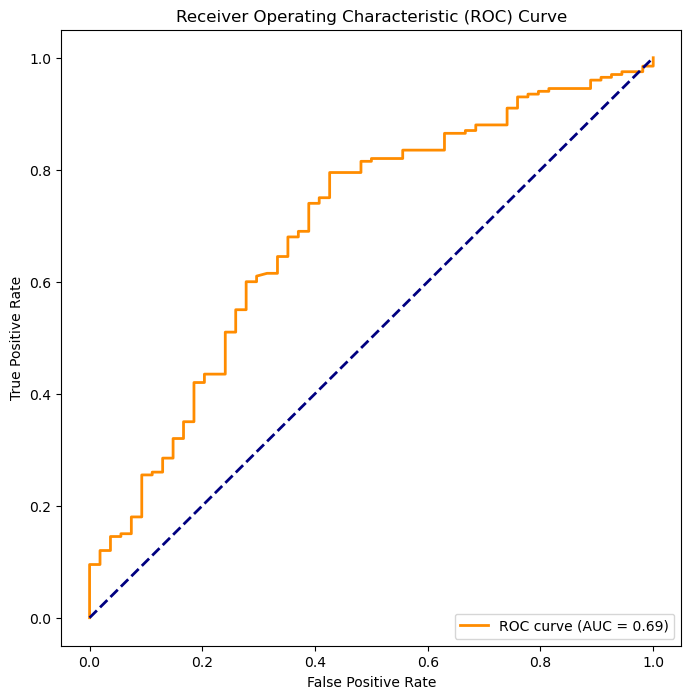

In [132]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Accuracy Classifier

In [142]:
df = pd.read_csv('data/accuracy.csv')
df['label'] = df['label'].astype('int')
df.to_csv('data/accuracy.csv')

In [133]:
df = pd.read_csv('data/accuracy.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/accuracy_balanced.csv')
df2

,Unnamed: 0,label,text
0,1205,0,"Question: LeBron James, the famous NBA player,..."
1,1112,0,Question: A cheerleading squad of 100 girls is...
2,2533,0,"Question: In a bakery, the baker bakes 200 bun..."
3,979,1,Question: Iron Man has 30000 nano-bots. 10000 ...
4,2328,0,Question: Black Panther is a superhero who can...
...,...,...,...
595,514,0,Question: 3248 is the same as 32.48 when it is...
596,1863,0,Question: 3 unicorns ate 21 apples. 7 unicorns...
597,879,0,Question: The 2:00 PM train from Penn Station ...
598,2242,1,"Question: Cedric, the ice cream man, has 120 s..."


In [83]:
# Load the dataset
dataset = load_dataset('csv', data_files="data/accuracy.csv")
#dataset = load_dataset('csv', data_files="data/accuracy.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

In [84]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [85]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "NOT ACCURATE", 1: "ACCURATE"}
label2id = {"NOT ACCURATE": 0, "ACCURATE": 1}

In [86]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
import torch.nn as nn
num_ftrs = model.classifier.in_features
num_classes = 2
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.4),               # Dropout layer with 20% probability
    nn.Linear(2048, num_classes)    # Final prediction fc layer
)

for param in model.bert.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'bert'

In [87]:
training_args = TrainingArguments(
    output_dir="accuracy_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = BertTrainer(penalty_factor = 2,
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,4.664889,0.864865
2,No log,4.001462,0.819820
3,No log,3.050168,0.878378
3,No log,4.293712,0.846154


KeyboardInterrupt: 

In [88]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 4.2937116622924805, 'eval_accuracy': 0.8461538461538461}

In [89]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.2440203 ,  1.5223162 ],
       [-0.6233132 ,  0.7790685 ],
       [-0.96761084,  1.1784246 ],
       [-1.2625561 ,  1.5459605 ],
       [-1.2511543 ,  1.5341315 ],
       [-1.0308281 ,  1.2612792 ],
       [-1.1869366 ,  1.4450778 ],
       [-1.127009  ,  1.3716851 ],
       [-1.2523204 ,  1.5372587 ],
       [-1.1117508 ,  1.3562235 ],
       [-1.1614438 ,  1.4168123 ],
       [-1.1285315 ,  1.3772497 ],
       [ 0.5784071 , -0.9037413 ],
       [-1.2550079 ,  1.536453  ],
       [-1.2607725 ,  1.5443048 ],
       [-1.129681  ,  1.377318  ],
       [-1.2776465 ,  1.5663002 ],
       [ 0.6388945 , -0.9863629 ],
       [-1.2820437 ,  1.5772834 ],
       [-1.2830944 ,  1.5766681 ],
       [-1.1743785 ,  1.4321872 ],
       [-0.74474156,  0.907014  ],
       [-1.1579347 ,  1.4140929 ],
       [-1.1754882 ,  1.4351927 ],
       [-1.21394   ,  1.4841042 ],
       [-0.29844674,  0.33376005],
       [-1.1508745 ,  1.4043765 ],
       [-0.90883744,  1.10

In [90]:
compute_fp_tp(predictions)

(0.8181818181818182, 0.9627659574468085)

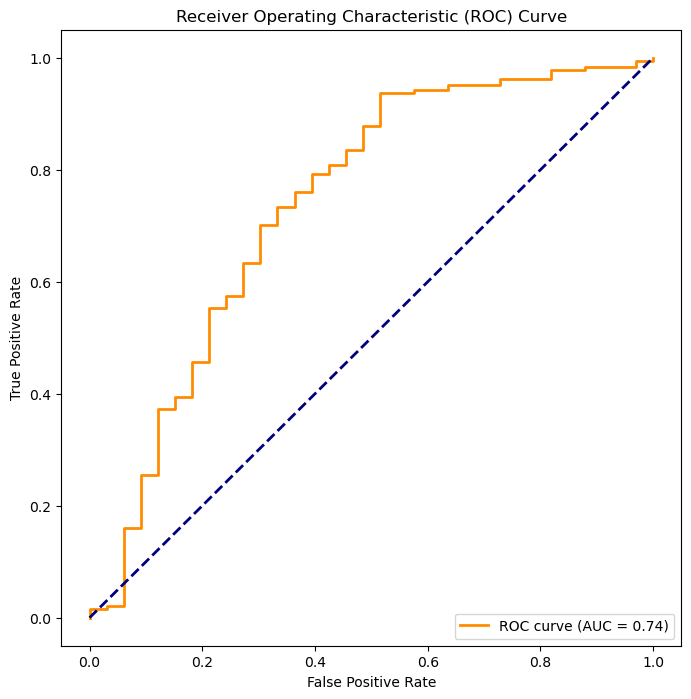

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Overall Goodness Classifier

In [174]:
df = pd.read_csv('data/good.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/good.csv')
df

,label,text
0,1,Question: A candy store has 45000 pieces of ca...
1,0,Question: The 12:05 p.m. train from New York t...
2,0,Question: Taylor Swift is on a 2-year contract...
3,1,Question: The Beverly Hills Bakery baked 200 l...
4,0,Question: There are 4 Ninja Turtles. 3 of them...
...,...,...
2536,0,Question: The volleyball team has 12 players. ...
2537,1,Question: Captain America is a superhero. He c...
2538,0,Question: 11111 is a 5-digit number. 22222 is ...
2539,1,Question: The T-Rex is 30 feet long. The Veloc...


In [175]:
# Load the dataset
dataset = load_dataset('csv', data_files="data/good.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [176]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2032 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [177]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "BAD", 1: "GOOD"}
label2id = {"BAD": 0, "GOOD": 1}

In [178]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [179]:
training_args = TrainingArguments(
    output_dir="good_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.631144,0.574803
2,No log,0.625854,0.602362
3,No log,0.582048,0.704724
4,0.548300,0.615226,0.740157
5,0.548300,0.790113,0.708661
6,0.548300,1.006566,0.696850
7,0.548300,1.183374,0.724409
8,0.185400,1.240531,0.692913


Dataset({
    features: ['Unnamed: 0', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 254
})


In [180]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.05403580e-01,  1.53633922e-01],
       [ 6.09290414e-02, -5.34317605e-02],
       [-4.42979664e-01,  3.64052027e-01],
       [ 7.41577387e-01, -5.98230779e-01],
       [-1.39217234e+00,  1.22615516e+00],
       [ 3.11386377e-01, -2.59676754e-01],
       [-8.81905794e-01,  7.69264221e-01],
       [ 3.58980715e-01, -2.98232138e-01],
       [-2.16182977e-01,  1.81804225e-01],
       [ 7.90851533e-01, -6.31054401e-01],
       [ 6.89657569e-01, -5.51742911e-01],
       [-1.31638515e+00,  1.14057374e+00],
       [ 7.78490365e-01, -6.26768827e-01],
       [-6.13770541e-03,  3.65272909e-02],
       [-4.17527884e-01,  3.33091706e-01],
       [ 9.64136273e-02, -5.37400506e-02],
       [ 7.72704840e-01, -6.20708764e-01],
       [-1.95953667e-01,  1.85208619e-01],
       [-1.33032691e+00,  1.12376618e+00],
       [-1.07179654e+00,  9.31076288e-01],
       [-8.86894882e-01,  7.71629632e-01],
       [-1.46392405e-01,  1.26147375e-01],
       [-1.03455544e-01, 

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Testing on IMDB Dataset

In [16]:
from datasets import load_dataset

imdb = load_dataset("imdb")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [17]:
import sys
#sys.path.append("/home/sagemaker-user/bitsandbytes")
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import bitsandbytes

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="text_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="steps",  # Change evaluation strategy to "steps"
    eval_steps=100,  # Set the evaluation frequency to every 100 steps
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb['train'],
    eval_dataset=tokenized_imdb['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.302497,0.876960
200,No log,0.250724,0.900440
300,No log,0.263815,0.904360


KeyboardInterrupt: 

In [6]:
conda list | grep cudatoolkit

cudatoolkit               11.8.0              h4ba93d1_12    conda-forge

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#11.8.0